# Novas perguntas do CEO para vocês


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import gridspec
from matplotlib import pyplot as plt
import ipywidgets as widgets
import plotly.express as px
from ipywidgets import interact, interactive, fixed, interact_manual
import time
import defs
from multiprocessing import Pool
from geopy.geocoders import Nominatim

ModuleNotFoundError: No module named 'plotly'

In [2]:
df=pd.read_csv('Datasets/kc_house_data.csv')
#df=pd.read_csv('Datasets/kc_house_data.csv',parse_dates=[1,14,15])

In [3]:
## # Supress Scientific Notation

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
# def jupyter_settings():
#     %matplotlib inline
#     %pylab inline

#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [25, 12]
#     plt.rcParams['font.size'] = 24

#     display( HTML( '<style>.container { width:100% !important; }</style>') )
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.set_option( 'display.expand_frame_repr', False )

#     sns.set()

# jupyter_settings()

## Qual a média do preço de compra dos imóveis por “Nível”? - 
- Nível 0 -> Preço entre R$ 0 e R$ 321.950 
- Nível 1 -> Preço entre R$ 321.950 e R$ 450.000 
- Nível 2 -> Preço entre R$ 450.000 e R$ 645.000 
- Nível 3 -> Acima de R$ 645.000


In [5]:
df['level']=df['price'].apply(lambda x:'level_00' if (x >=0)&(x<321950) else
                                      '1evel_01' if (x >=321950)&(x<450000) else
                                      '1evel_02' if (x >=45000)&(x<645000) else '1evel_03')

## Qual a média do tamanho da sala de estar dos imóveis por “Size” ? 
- Size 0 -> Tamanho entre 0 e 1427 sqft 
- Size 1 -> Tamanho entre 1427 e 1910 sqft 
- Size 2 -> Tamanho entre 1910 e 2550 sqft 
- Size 3 -> Tamanho acima de 2550 sqft

In [6]:
df['size']=df['sqft_living'].apply(lambda x:'s00' if (x >=0)&(x<1427) else
                                      's01' if (x >=1427)&(x<1910) else
                                      's02' if (x >=1910)&(x<2550) else 's03')

In [7]:
df[['size','sqft_living']].groupby('size').mean().reset_index()

,size,sqft_living
0,s00,1123.78
1,s01,1661.20
2,s02,2202.70
3,s03,3318.99


## Adicione as seguinte informações ao conjunto de dados original: 
- Place ID: Identificação da localização 
- OSM Type: Open Street Map type 
- Country: Nome do País 
- Country Code: Código do País


In [8]:
df['query']=df[['lat','long']].apply(lambda x: str(x['lat'])+','+str(x['long']),axis=1)

In [9]:
import defs

df1=df[['id','query']].head()
p=Pool(2)

start=time.process_time()

df1[['place_id', 'osm_type', 'country', 'country_code']] =p.map( defs.get_longlat, df1.iterrows() )

end=time.process_time()

print(time.process_time() - start)

ModuleNotFoundError: No module named 'geopy'

## Adicione os seguinte filtros no Mapa: 
- Tamanho mínimo da área da sala de estar. 
- Número
mínimo de banheiros. 
- Valor Máximo do Preço. 
- Tamanho máximo da área do porão. 
-Filtro das Condições do Imóvel. 
- Filtro por Ano de Construção.


In [27]:
# Prepare data
    
df['is_waterfront'] = df['waterfront'].apply( lambda x: 'yes' if x == 1 else 'no' )

# # define level of prices

df['level']=df['price'].apply(lambda x:  0 if x<=321950 else
                                         1 if (x>321950)&(x<=450000)else
                                         2 if (x>450000)&(x<=645000)else 3)
df['level'] = df['level'].astype(int)

# Iteractive buttons

price_limit = widgets.IntSlider(
    value = int(df['price'].mean()),min = int(df['price'].min()),
    max = int(df['price'].max()),step = 1,description='Maximun Price',
    disable=False,style={'description_width': 'initial'}
    )

waterfront_bar = widgets.Dropdown(
    options = df['is_waterfront'].unique().tolist(),
    value = 'no',
    description = 'Water View',
    disable=False
    )

livingroom_limit = widgets.IntSlider(
    value = int( df['sqft_living'].mean() ),
    min = df['sqft_living'].min(),
    max = df['sqft_living'].max(),
    step = 1,
    description='Minimum Living Room Size',
    disable=False,
    style={'description_width': 'initial'}
)

bathroom_limit = widgets.IntSlider(
    value = int( df['bathrooms'].mean() ),
    min = df['bathrooms'].min(),
    max = df['bathrooms'].max(),
    step = 1,
    description='Minimum Bathroom Number',
    disable=False,
    style={'description_width': 'initial'}
)

basement_limit = widgets.IntSlider(
    value = int( df['sqft_basement'].mean() ),
    min = df['sqft_basement'].min(),
    max = df['sqft_basement'].max(),
    step = 1,
    description='Minimum Basement Size',
    disable=False,
    style={'description_width': 'initial'}
)

condition_limit = widgets.IntSlider(
    value = int( df['condition'].mean() ),
    min = df['condition'].min(),
    max = df['condition'].max(),
    step = 1,
    description='Minimum condition',
    disable=False,
    style={'description_width': 'initial'}
)

year_limit = widgets.IntSlider(
    value = int( df['yr_built'].mean() ),
    min = df['yr_built'].min(),
    max = df['yr_built'].max(),
    step = 1,
    description='Year Built',
    disable=False,
    style={'description_width': 'initial'}
)

In [28]:
def update_map( df, waterfront, limit, livingroom_limit, bathroom_limit,basement_limit, 
               condition_limit, year_limit ):
    houses = df[(df['price'] <= limit) &
    (df['is_waterfront'] == waterfront) &
    (df['sqft_living'] >= livingroom_limit) &
    (df['bathrooms'] >= bathroom_limit) &
    (df['sqft_basement'] >= basement_limit) &
    (df['condition'] >= condition_limit) &
    (df['yr_built'] >= year_limit )][['id', 'lat', 'long', 'price','level']]
    
#plot map
    fig = px.scatter_mapbox( houses,
            lat="lat",
            lon="long",
            size="price",
            color="level",
            color_continuous_scale=px.colors.cyclical.IceFire,
            size_max=15,
            zoom=10)

    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(height=600, margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()                    

In [29]:
widgets.interactive( update_map,
    df=fixed( df ),
    waterfront=waterfront_bar,
    limit=price_limit,
    livingroom_limit=livingroom_limit,
    bathroom_limit=bathroom_limit,
    basement_limit=basement_limit,
    condition_limit=condition_limit,
    year_limit=year_limit
)

interactive(children=(Dropdown(description='Water View', options=('no', 'yes'), value='no'), IntSlider(value=5…

## Adicione os seguinte filtros no Dashboard: 
- Filtro por data disponível para compra. 
- Filtro por ano de renovação. 
- Filtro se possui vista para a água ou não.

In [40]:
# Change df format
df['year'] = pd.to_datetime( df['date'] ).dt.strftime( '%Y' )
df['date'] = pd.to_datetime( df['date'] ).dt.strftime( '%Y-%m-%d' )
df['year_week'] = pd.to_datetime( df['date'] ).dt.strftime( '%Y-%U' )

# # ----------------------------
# # Filtering
# # ----------------------------

# Widget to control df
date_limit = widgets.SelectionSlider(
options = df['date'].sort_values().unique().tolist(),
value='2014-12-01',
description='Max Available Date',
disable=False,
continuous_update=False,
orientation='horizontal',
style={'description_width': 'initial'},
readout=True
)
# # Max Year Renovated
year_limit = widgets.SelectionSlider(
options = df['yr_renovated'].sort_values().sort_values().unique().tolist(),
value=2000,
description='Max Year',
disable=False,
continuous_update=False,
orientation='horizontal',
style={'description_width': 'initial'},
readout=True
)
# # Waterfront
waterfront_limit = widgets.Checkbox(
value=False,
description='Waterfront?',
disabled=False,
indent=False )
    
def update_map( df, date_limit, year_limit, waterfront_limit ):
    # Filter df
    df = df[(df['date'] <= date_limit) & 
            (df['yr_renovated'] >= year_limit) & 
            (df['waterfront'] == waterfront_limit)].copy()
    
    fig = plt.figure( figsize=(24, 12) )
    specs = gridspec.GridSpec( ncols=2, nrows=2, figure=fig )
    
    ax1 = fig.add_subplot( specs[0, :] ) # First Row
    ax2 = fig.add_subplot( specs[1, 0] ) # First Row First Column
    ax3 = fig.add_subplot( specs[1, 1] ) # Second Row First Column
    
    # First Graph
    by_year = df[['price', 'year']].groupby( 'year' ).count().reset_index()
    sns.barplot( x = 'year', y ='price', data=by_year, ax=ax1)
    
#   # Second Graph

    by_day = df[['price', 'date']].groupby( 'date' ).mean().reset_index()
    sns.lineplot( x='date', y='price',data=by_day, ax=ax2)
    ax2.set_title( "Title: Avg Price by Day" )
    
#   # Third Graph
    
    df['year_week'] = pd.to_datetime( df['date'] ).dt.strftime( '%Y-%U' )
    by_week_of_year = df[['price', 'year_week']].groupby( 'year_week' ).mean().reset_index()
    sns.barplot( x='year_week', y='price', data=by_week_of_year,ax=ax3 )
    ax3.set_title( "Title: Avg Price by Week of Year" )
    
    plt.xticks( rotation=60);



interactive(children=(SelectionSlider(continuous_update=False, description='Max Available Date', index=212, op…

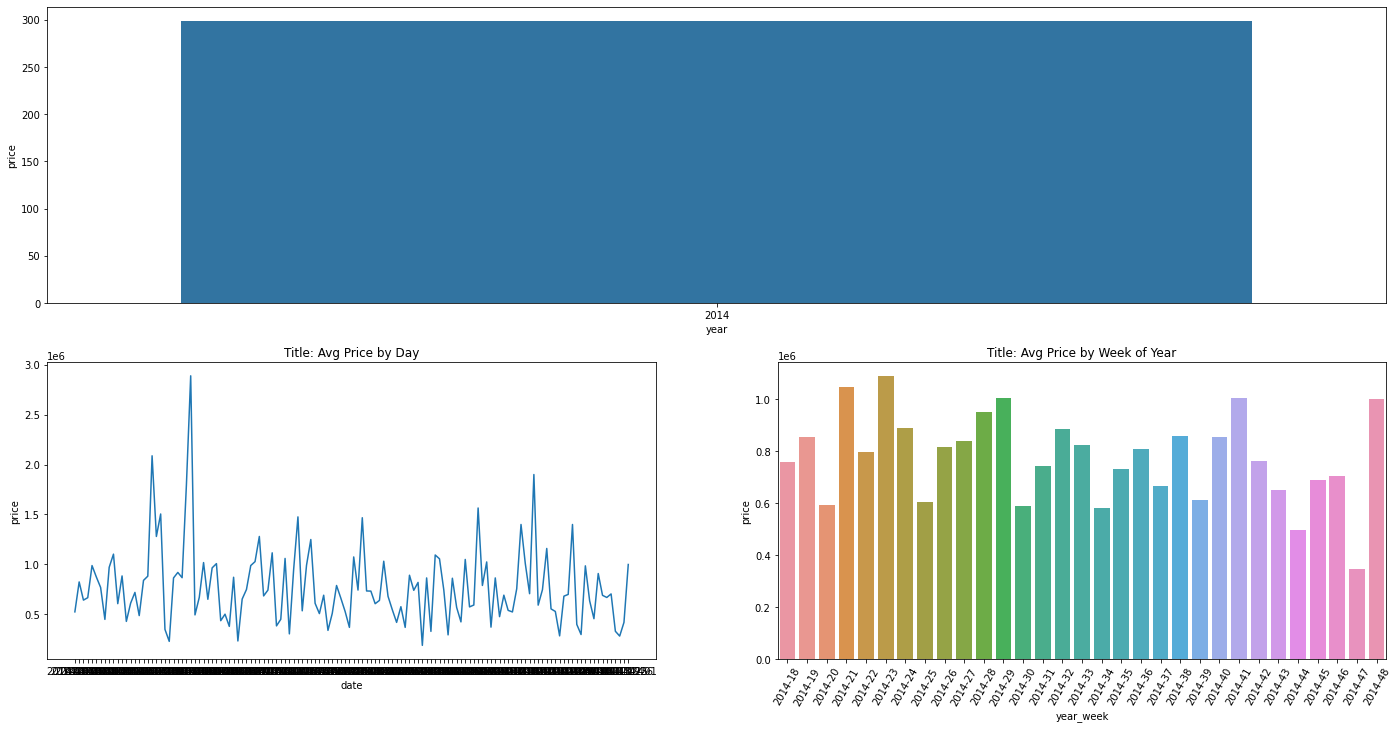

In [41]:
widgets.interactive( update_map,df = fixed(df),
date_limit=date_limit,
year_limit=year_limit,
waterfront_limit=waterfront_limit )

In [34]:
df['month'] = pd.to_datetime( df['date'] ).dt.strftime('%m')
df['month']=df['month'].astype(int)

In [35]:
df['season']=df['month'].apply(lambda x:'spring' if (x >=4)&(x<7) else
                                      'summer' if (x >=7)&(x<10) else
                                      'fall' if (x >=10)&(x<12) else 'winter')

In [38]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,level,size,query,month,season
0,7129300520,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,...,98178,47.51,-122.26,1340,5650,level_00,s00,"47.5112,-122.257",10,fall
1,6414100192,20141209T000000,538000.00,3,2.25,2570,7242,2.00,0,0,...,98125,47.72,-122.32,1690,7639,1evel_02,s03,"47.721,-122.319",12,winter
2,5631500400,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,...,98028,47.74,-122.23,2720,8062,level_00,s00,"47.7379,-122.233",2,winter
3,2487200875,20141209T000000,604000.00,4,3.00,1960,5000,1.00,0,0,...,98136,47.52,-122.39,1360,5000,1evel_02,s02,"47.5208,-122.393",12,winter
4,1954400510,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,...,98074,47.62,-122.05,1800,7503,1evel_02,s01,"47.6168,-122.045",2,winter


In [43]:
df1=df.groupby(['zipcode','season'], as_index=False)['price'].median()
df1.head()

,zipcode,season,price
0,98001,fall,243975.00
1,98001,spring,265000.00
2,98001,summer,260000.00
3,98001,winter,258000.00
4,98002,fall,234000.00
